# Task 4 - Optimized Buckets

In [37]:
import numpy as np
import pandas as pd
from scipy.stats import binom
import matplotlib.pyplot as plt

In [38]:
# load data
fico = pd.read_csv('loan_data.csv')
fico

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0
...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0


In [39]:
#intialize 4 buckets, will change in later code
num_buckets = 4
fico['bucket'] = pd.cut(fico['fico_score'],bins=num_buckets,labels=False)

fico

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,bucket
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0,1
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0,1
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0,1
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0,2
...,...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0,2
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0,1
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0,1
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0,2


# Calculate Log-Likelihood

Initial Log-likelihood:  -13.463435690611455


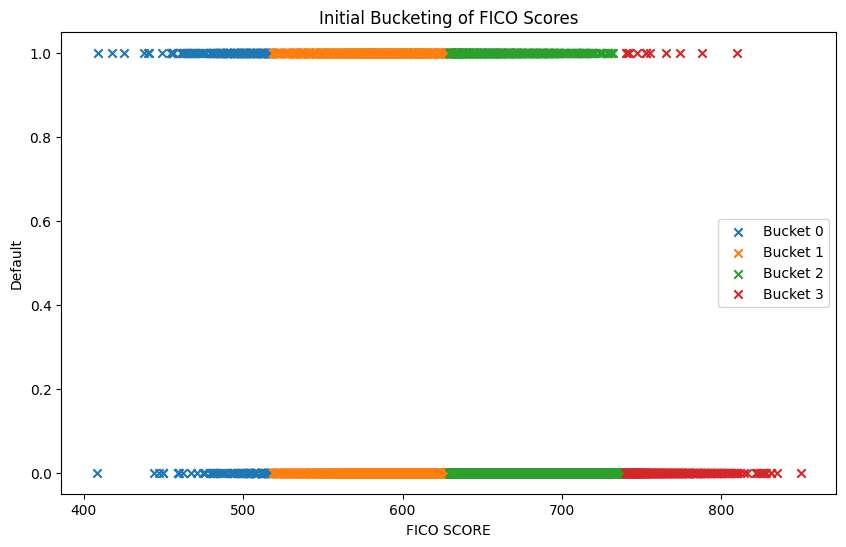

In [40]:
#function to calculate log-likelihood
def calculate_log_likelihood(data):
	log_likelihood = 0
	for b in range(num_buckets):
		bucket_data = fico[fico['bucket']== b]
		if not bucket_data.empty:
			ni = len(bucket_data)
			ki = bucket_data['default'].sum()
			pi = ki/ni if ni > 0 else 0
			log_likelihood += binom.logpmf(ki,ni,pi) #log probability mass function
	return log_likelihood

initial_log_likelihood = calculate_log_likelihood(fico)
print("Initial Log-likelihood: ",initial_log_likelihood)

#plot the separation of buckets
plt.figure(figsize=(10,6))
for b in range(num_buckets):
	bucket_data = fico[fico['bucket']==b]
	plt.scatter(bucket_data['fico_score'],bucket_data['default'],label=f'Bucket {b}',marker='x')
plt.xlabel("FICO SCORE")
plt.ylabel("Default")
plt.legend()
plt.title("Initial Bucketing of FICO Scores")
plt.show()

# Optimize the Range of the Buckets

In [41]:
#function to optimize the range of the buckets by using a range of 10 on both sides
def optimize_buckets(data,num_buckets,max_iterations=100):

	#initialize boundaries
	boundaries = np.linspace(fico['fico_score'].min(),fico['fico_score'].max(),num_buckets+1)
	best_likelihood = calculate_log_likelihood(data)
	improved=True
	iteration = 0

	#continue iterating until improvement of boundaries stops
	while improved and iteration < max_iterations:
		improved = False
		for i in range(1,len(boundaries)-1): #adjust internal boundaries
			original_boundary = boundaries[i]
			#try shifting the boundary up or down
			for shift in (-10,10):
				boundaries[i] += shift
				fico['bucket'] = pd.cut(fico['fico_score'],bins=boundaries,labels=False,include_lowest=True)
				new_likelihood = calculate_log_likelihood(data)
				if new_likelihood > best_likelihood:
					best_likelihood = new_likelihood
					improved = True
				else:
					boundaries[i] = original_boundary
		iteration +=1
		print(f"Iteration {iteration},log-likelihood: {best_likelihood}")
	return boundaries

In [42]:
#optimize the buckets
final_boundaries = optimize_buckets(fico,num_buckets)

#update the data with the optimized buckets
fico['bucket'] = pd.cut(fico['fico_score'],bins=final_boundaries,labels=False,include_lowest=True)
final_boundaries

Iteration 1,log-likelihood: -13.231444113073707
Iteration 2,log-likelihood: -12.90355559322127
Iteration 3,log-likelihood: -12.748672117234278
Iteration 4,log-likelihood: -12.748672117234278


array([408. , 518.5, 629. , 759.5, 850. ])

# Optimize the Number of Buckets

In [43]:
#function to optimize the number of buckets
def optimize_bucket_count(data,min_buckets,max_buckets):

	#initialize variables
	best_overall_likelihood = float('-inf')
	best_overall_count = min_buckets
	best_boundaries = None

	#iterate through all possible bucket counts
	for num_buckets in range(min_buckets,max_buckets+1):

		#test bucket
		print(f"Testing {num_buckets} buckets...")
		boundaries = np.linspace(data['fico_score'].min(),data['fico_score'].max(),num_buckets+1)
		data['bucket'] = pd.cut(data['fico_score'],bins=boundaries,labels=False,include_lowest=True)
		initial_likelihood = calculate_log_likelihood(data)

		#optimize boundaries
		boundaries = optimize_buckets(data,num_buckets) 
		data['bucket'] = pd.cut(data['fico_score'],bins=boundaries,labels=False,include_lowest=True)
		final_likelihood = calculate_log_likelihood(data)

		print(f"Boundaries for {num_buckets} buckets: {boundaries}")
		print(f"Log-likelihood for {num_buckets} buckets: {final_likelihood}")

		#change optimal boundaries if improvement
		if final_likelihood > best_overall_likelihood:
			best_overall_likelihood = final_likelihood
			best_overall_count = num_buckets
			best_boundaries = boundaries

	return best_overall_count,best_boundaries,best_overall_likelihood

#test example
best_count, best_boundaries, best_likelihood = optimize_bucket_count(fico,4,10)
print(f"Best number of buckets: {best_count} with log-likelihood of {best_likelihood}")

Testing 4 buckets...
Iteration 1,log-likelihood: -13.231444113073707
Iteration 2,log-likelihood: -12.90355559322127
Iteration 3,log-likelihood: -12.748672117234278
Iteration 4,log-likelihood: -12.748672117234278
Boundaries for 4 buckets: [408.  518.5 629.  759.5 850. ]
Log-likelihood for 4 buckets: -12.90355559322127
Testing 5 buckets...
Iteration 1,log-likelihood: -13.979545291440058
Iteration 2,log-likelihood: -13.979545291440058
Boundaries for 5 buckets: [408.  496.4 584.8 673.2 761.6 850. ]
Log-likelihood for 5 buckets: -14.17134023324185
Testing 6 buckets...
Iteration 1,log-likelihood: -13.673687492432771
Iteration 2,log-likelihood: -13.673687492432771
Boundaries for 6 buckets: [408.         481.66666667 555.33333333 629.         702.66666667
 776.33333333 850.        ]
Log-likelihood for 6 buckets: -13.908722321592865
Testing 7 buckets...
Iteration 1,log-likelihood: -13.057220612790225
Iteration 2,log-likelihood: -13.057220612790225
Boundaries for 7 buckets: [408.         471.142

# Plot the Final Bucket Separation

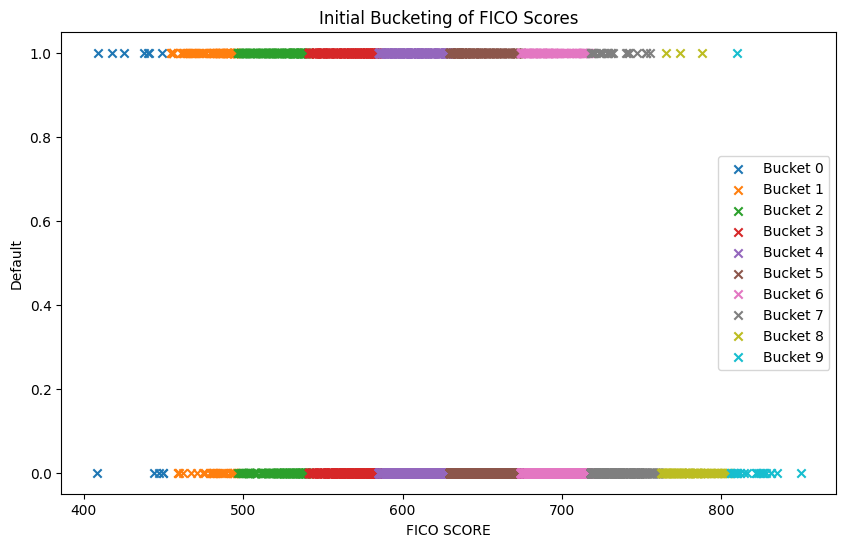

In [46]:
# Plot final bucketing

num_buckets = best_count
final_boundaries = best_boundaries

#update the dataframe with the optimal bucket assignment
fico['bucket'] = pd.cut(fico['fico_score'],bins=final_boundaries,labels=False,include_lowest=True)

plt.figure(figsize=(10,6))
for b in range(num_buckets):
	bucket_data = fico[fico['bucket']==b]
	plt.scatter(bucket_data['fico_score'],bucket_data['default'],label=f'Bucket {b}',marker='x')

plt.xlabel("FICO SCORE")
plt.ylabel("Default")
plt.legend()
plt.title("Initial Bucketing of FICO Scores")
plt.show()